In [ ]:
## install finrl library
!pip install wrds
!pip install swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 82.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 65.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-j7k3uml0
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-j7k3uml0
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit d5561cfcbcf3073e01ce70d11d46a7d9a5766948
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

In [ ]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [ ]:
TRAIN_START_DATE = '2015-02-02'
TRAIN_END_DATE = '2021-02-17'
TRADE_START_DATE = '2021-02-18'
TRADE_END_DATE = '2022-02-18'

In [ ]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ["TCS"]).fetch_data()


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2013, 8)


In [ ]:
df.shape

(2013, 8)

In [ ]:
!pwd

/content


In [ ]:
df = pd.read_csv("TCS.csv")

In [ ]:
df.head()

,date,open,high,low,close,volume
0,2015-02-02 09:15:00+05:30,1241.00,1243.63,1238.53,1239.10,36770
1,2015-02-02 09:16:00+05:30,1239.88,1240.95,1238.35,1238.68,18892
2,2015-02-02 09:17:00+05:30,1239.00,1239.00,1237.50,1237.50,12792
3,2015-02-02 09:18:00+05:30,1237.50,1237.50,1236.65,1236.85,17498
4,2015-02-02 09:19:00+05:30,1236.85,1237.63,1236.00,1236.48,10266


In [ ]:
df.shape

(651976, 6)

In [ ]:
tic = ['TCS']*(df.shape[0])

In [ ]:
df['tic'] = tic

In [ ]:
df.head()

,date,open,high,low,close,volume,tic
0,2015-02-02 09:15:00+05:30,1241.00,1243.63,1238.53,1239.10,36770,TCS
1,2015-02-02 09:16:00+05:30,1239.88,1240.95,1238.35,1238.68,18892,TCS
2,2015-02-02 09:17:00+05:30,1239.00,1239.00,1237.50,1237.50,12792,TCS
3,2015-02-02 09:18:00+05:30,1237.50,1237.50,1236.65,1236.85,17498,TCS
4,2015-02-02 09:19:00+05:30,1236.85,1237.63,1236.00,1236.48,10266,TCS


In [ ]:
pf = df

In [ ]:
pf.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic
0,2015-02-02 09:15:00+05:30,1241.00,1243.63,1238.53,1239.10,36770,TCS
1,2015-02-02 09:16:00+05:30,1239.88,1240.95,1238.35,1238.68,18892,TCS
2,2015-02-02 09:17:00+05:30,1239.00,1239.00,1237.50,1237.50,12792,TCS
3,2015-02-02 09:18:00+05:30,1237.50,1237.50,1236.65,1236.85,17498,TCS
4,2015-02-02 09:19:00+05:30,1236.85,1237.63,1236.00,1236.48,10266,TCS


In [ ]:
s = " 09:15:00+05:30	"
len(s)

16

In [ ]:
testing_df = df[:100]

In [ ]:
testing_df

,date,open,high,low,close,volume,tic
0,2015-02-02 09:15:00+05:30,1241.00,1243.63,1238.53,1239.10,36770,TCS
1,2015-02-02 09:16:00+05:30,1239.88,1240.95,1238.35,1238.68,18892,TCS
2,2015-02-02 09:17:00+05:30,1239.00,1239.00,1237.50,1237.50,12792,TCS
3,2015-02-02 09:18:00+05:30,1237.50,1237.50,1236.65,1236.85,17498,TCS
4,2015-02-02 09:19:00+05:30,1236.85,1237.63,1236.00,1236.48,10266,TCS
...,...,...,...,...,...,...,...
95,2015-02-02 10:50:00+05:30,1251.40,1251.73,1250.25,1250.63,18948,TCS
96,2015-02-02 10:51:00+05:30,1250.63,1250.88,1250.63,1250.63,466,TCS
97,2015-02-02 10:52:00+05:30,1250.63,1250.98,1250.58,1250.75,2072,TCS
98,2015-02-02 10:53:00+05:30,1250.75,1251.43,1250.75,1251.25,20360,TCS


In [ ]:
testing_df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [ ]:
testing_df

,date,open,high,low,close,volume,tic
0,2015-02-02 09:15:00+05:30,1241.00,1243.63,1238.53,1239.10,36770,TCS
1,2015-02-02 09:16:00+05:30,1239.88,1240.95,1238.35,1238.68,18892,TCS
2,2015-02-02 09:17:00+05:30,1239.00,1239.00,1237.50,1237.50,12792,TCS
3,2015-02-02 09:18:00+05:30,1237.50,1237.50,1236.65,1236.85,17498,TCS
4,2015-02-02 09:19:00+05:30,1236.85,1237.63,1236.00,1236.48,10266,TCS
...,...,...,...,...,...,...,...
95,2015-02-02 10:50:00+05:30,1251.40,1251.73,1250.25,1250.63,18948,TCS
96,2015-02-02 10:51:00+05:30,1250.63,1250.88,1250.63,1250.63,466,TCS
97,2015-02-02 10:52:00+05:30,1250.63,1250.98,1250.58,1250.75,2072,TCS
98,2015-02-02 10:53:00+05:30,1250.75,1251.43,1250.75,1251.25,20360,TCS


In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=False,
                    use_turbulence=False,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators


In [ ]:
processed

,date,open,high,low,close,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2015-02-02 09:15:00+05:30,1241.00,1243.63,1238.53,1239.10,36770,TCS,0.000000,1239.483970,1238.296030,0.000000,-66.666667,100.000000,1239.100000,1239.100000
1,2015-02-02 09:16:00+05:30,1239.88,1240.95,1238.35,1238.68,18892,TCS,-0.009423,1239.483970,1238.296030,0.000000,-66.666667,100.000000,1238.890000,1238.890000
2,2015-02-02 09:17:00+05:30,1239.00,1239.00,1237.50,1237.50,12792,TCS,-0.048599,1240.085743,1236.767591,0.000000,-100.000000,100.000000,1238.426667,1238.426667
3,2015-02-02 09:18:00+05:30,1237.50,1237.50,1236.65,1236.85,17498,TCS,-0.088693,1240.111177,1235.953823,0.000000,-94.756554,100.000000,1238.032500,1238.032500
4,2015-02-02 09:19:00+05:30,1236.85,1237.63,1236.00,1236.48,10266,TCS,-0.123336,1239.995517,1235.448483,0.000000,-83.508772,100.000000,1237.722000,1237.722000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651971,2022-02-18 15:25:00+05:30,3791.10,3792.10,3791.00,3792.10,25185,TCS,-0.505475,3796.590939,3790.374061,48.196854,-116.985951,15.462151,3794.316667,3792.280000
651972,2022-02-18 15:26:00+05:30,3792.00,3793.00,3792.00,3792.15,21386,TCS,-0.508014,3796.382419,3790.277581,48.273507,-81.704648,7.611968,3794.165000,3792.395000
651973,2022-02-18 15:27:00+05:30,3792.85,3793.90,3792.20,3793.35,25171,TCS,-0.408486,3796.018295,3790.391705,50.106470,-42.883164,0.320835,3794.068333,3792.492500
651974,2022-02-18 15:28:00+05:30,3793.15,3796.00,3793.05,3795.45,32919,TCS,-0.158333,3796.311400,3790.343600,53.114230,36.728274,14.182011,3794.083333,3792.617500


In [ ]:
df.shape

(651976, 7)

In [ ]:
train = data_split(processed, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

558693
92533


In [ ]:
train.tail()

,date,open,high,low,close,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
558688,2021-02-16 15:25:00+05:30,3111.95,3113.00,3109.4,3110.35,8645,TCS,0.498422,3112.768508,3105.111492,52.713509,113.568216,2.124025,3108.961667,3108.913333
558689,2021-02-16 15:26:00+05:30,3111.00,3112.75,3110.0,3111.25,4860,TCS,0.596593,3112.962567,3105.062433,54.121210,126.664235,2.124025,3109.063333,3108.915000
558690,2021-02-16 15:27:00+05:30,3111.50,3111.65,3110.0,3111.05,6550,TCS,0.650754,3113.143397,3105.041603,53.753344,95.270591,2.124025,3109.150000,3108.914167
558691,2021-02-16 15:28:00+05:30,3110.05,3111.65,3110.0,3111.00,8468,TCS,0.681784,3113.304785,3105.030215,53.659019,87.539751,2.124025,3109.250000,3108.898333
558692,2021-02-16 15:29:00+05:30,3111.00,3113.20,3110.1,3113.00,3883,TCS,0.857869,3113.843550,3104.891450,56.796118,139.670963,10.506980,3109.430000,3108.935833


In [ ]:
trade.head()

,date,open,high,low,close,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2021-02-18 09:15:00+05:30,3065.00,3069.70,3051.70,3066.25,99035,TCS,0.080524,3079.024517,3068.835483,40.741847,-350.581199,67.986857,3073.081667,3072.948333
1,2021-02-18 09:16:00+05:30,3064.75,3066.45,3055.60,3065.90,41375,TCS,-0.538321,3079.790206,3067.319794,40.386935,-283.014684,67.986857,3072.858333,3072.804167
2,2021-02-18 09:17:00+05:30,3067.95,3072.65,3060.15,3069.90,34451,TCS,-0.697948,3079.859897,3067.000103,45.953214,-128.656778,40.931716,3072.781667,3072.721667
3,2021-02-18 09:18:00+05:30,3071.30,3072.30,3064.00,3066.00,25677,TCS,-1.126169,3080.309395,3065.830605,41.997917,-119.850445,40.931716,3072.581667,3072.571667
4,2021-02-18 09:19:00+05:30,3066.50,3067.40,3061.00,3061.95,34360,TCS,-1.771913,3081.274652,3063.720348,38.443264,-185.057887,45.761617,3072.228333,3072.355000


In [ ]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4  
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [ ]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = False

In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None


--------------------------------------
| time/                 |            |
|    fps                | 17         |
|    iterations         | 100        |
|    time_elapsed       | 28         |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -1.45      |
|    explained_variance | -3.34      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -1.04      |
|    reward             | -0.0362583 |
|    std                | 1.03       |
|    value_loss         | 0.224      |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 17         |
|    iterations         | 200        |
|    time_elapsed       | 55         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -1.46      |
|    explained_variance | -22.7      |
|    learning_rate      |

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [ ]:
trained_model = trained_a2c
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_model   , 
    environment = e_trade_gym)

hit end!


In [ ]:
df_account_value.shape


(92533, 2)

In [ ]:
df_account_value.tail()


,date,account_value
92528,2022-02-17 15:25:00+05:30,1230599.395
92529,2022-02-17 15:26:00+05:30,1230648.145
92530,2022-02-17 15:27:00+05:30,1230729.395
92531,2022-02-17 15:28:00+05:30,1231151.895
92532,2022-02-17 15:29:00+05:30,1231899.395


In [ ]:
  df_account_value.to_csv("predictions_from_a2c_TCS.csv")

In [ ]:
trained_a2c.save("./trained_a2c")

In [ ]:
ac_value = df_account_value['account_value']

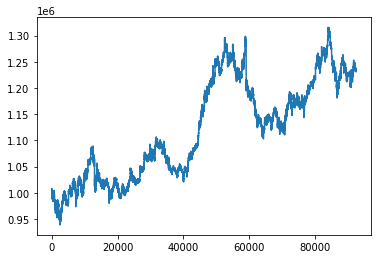

In [ ]:
acv = df_account_value['account_value']
plt.plot(acv)

In [ ]:
%ls  

In [ ]:
trained_a2c.save("/trained_a2c")

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========


TypeError: ignored

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

==============Compare to DJIA===========


TypeError: ignored